In [2]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 10
rcParams['axes.linewidth'] = 2

In [4]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

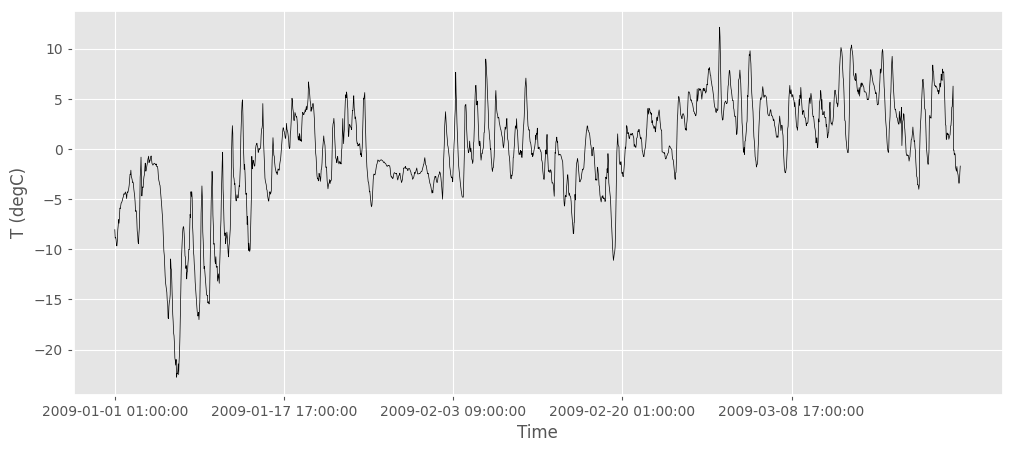

In [5]:
plt.plot(time[:2000], load[:2000], label = 'Real', color = 'k', linewidth = 0.5)
plt.xticks(np.arange(0, 2000, step = 400))
plt.xlabel('Time')
plt.ylabel('T (degC)')
plt.show()

In [ ]:
display(load.describe())

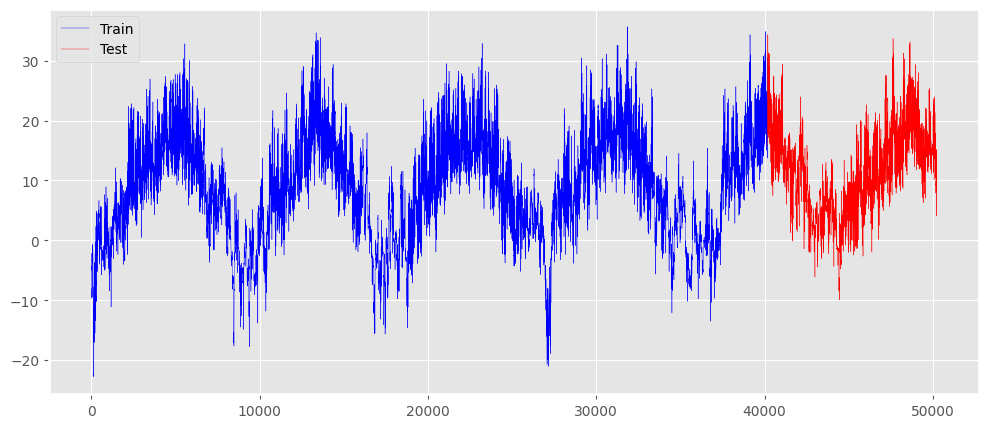

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train, label='Train', color='blue', linewidth=0.3)
plt.plot(test, label='Test', color='red', linewidth=0.3)
plt.legend()
plt.show()

In [ ]:
plt.figure()
acf_values = acf(train)
plot_acf(train, lags=50)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=50)
plt.show()

In [7]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1,4):
    df_train["lag{}".format(i)] = df_train["T (degC)"].shift(i)
    df_test["lag{}".format(i)] = df_test["T (degC)"].shift(i)

# df_train = pd.merge(df_train, other_vars_train, left_index=True, right_index=True, how = 'outer')
# df_test = pd.merge(df_test, other_vars_test, left_index=True, right_index=True, how = 'outer')

df_train = df_train.fillna(0)
df_train = df_train.drop(columns = ["T (degC)"])
df_test = df_test.fillna(0)
df_test = df_test.drop(columns = ["T (degC)"])

display(df_train, df_test)

,lag1,lag2,lag3
0,0.00,0.00,0.00
1,-8.05,0.00,0.00
2,-8.88,-8.05,0.00
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,0.00,0.00,0.00
40180,15.89,0.00,0.00
40181,16.37,15.89,0.00
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# ARIMA

In [ ]:
# Build Model
arima = ARIMA(train, order=(2, 1, 5)).fit()
print(arima.summary())

In [ ]:
# plotting
arima_fc = arima.forecast(len(test)) 

# Make as pandas series
fc_series = pd.Series(arima_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
# plt.plot(train, label='training', linewidth = 0.5, c = 'b')
plt.plot(test_series, label='actual', linewidth = 0.5, c = 'r')
plt.plot(fc_series, label='forecast', linewidth = 0.5, c = 'g')
# plt.plot(arima.predict(), label = 'fit')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [ ]:
RMSE_ARIMA = mean_squared_error(test, arima_fc)
MAE_ARIMA  =mean_absolute_error(test, arima_fc)
MAPE_ARIMA = mean_absolute_percentage_error(test, arima_fc)
print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))

In [ ]:
plt.plot(arima.resid, label = 'Residuals', linewidth = 0.3)
# plt.savefig('arimaresid')
plt.show()

In [ ]:
plt.plot(arima_fc, label = 'predict', linewidth = 0.5)
plt.plot(test, label = 'actual', linewidth = 0.5, color = 'k')
plt.legend()
plt.show()

In [ ]:
plt.plot(arima_fc[:400], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:400], label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [18]:
arima_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
arima_SVR.fit(df_train.values, arima.resid)
arima_SVR_fc = arima_SVR.predict(np.array(df_test))

In [ ]:
plt.plot(arima_SVR_fc+arima_fc, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test, label = 'actual', linewidth = 0.5, color = 'k')
plt.legend()
plt.show()

In [ ]:
RMSE_arima_svm = mean_squared_error(test, arima_SVR_fc+arima_fc)
MAE_arima_svm  =mean_absolute_error(test, arima_SVR_fc+arima_fc)
MAPE_arima_svm = mean_absolute_percentage_error(test, arima_SVR_fc+arima_fc)
print('RMSE = {}'.format(RMSE_arima_svm), '\nMAE = {}'.format(MAE_arima_svm), '\nMAPE = {}'.format(MAPE_arima_svm))

In [ ]:
plt.plot(arima_SVR_fc[:400]+arima_fc[:400], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:400], label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

# SVM

In [22]:
SVR_m = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(df_train.values, train)
SVR_fc = SVR_m.predict(np.array(df_test))

In [ ]:
plt.plot(SVR_fc, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

In [ ]:
plt.plot(SVR_fc[:400], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values[:400], label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [ ]:
RMSE_SVR = mean_squared_error(test, SVR_fc)
MAE_SVR  =mean_absolute_error(test, SVR_fc)
MAPE_SVR = mean_absolute_percentage_error(test, SVR_fc)
print('RMSE = {}'.format(RMSE_SVR), '\nMAE = {}'.format(MAE_SVR), '\nMAPE = {}'.format(MAPE_SVR))

# Empirical M Decomposition - SVM

In [ ]:
!pip install emd

In [ ]:
import emd

imf = emd.sift.sift(np.array(train), imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)
plt.show()

In [ ]:
imf_df = pd.DataFrame(data = imf)
imf_df.columns = ['imf_{}'.format(i+1) for i in range(0, imf.shape[1])]
display(imf_df)

In [30]:
imf1_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_SVR.fit(df_train.values, imf_df['imf_1'])
imf1_SVR_fc = imf1_SVR.predict(np.array(df_test))

imf2_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_SVR.fit(df_train.values, imf_df['imf_2'])
imf2_SVR_fc = imf2_SVR.predict(np.array(df_test))

imf3_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_SVR.fit(df_train.values, imf_df['imf_3'])
imf3_SVR_fc = imf3_SVR.predict(np.array(df_test))

imf4_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_SVR.fit(df_train.values, imf_df['imf_4'])
imf4_SVR_fc = imf4_SVR.predict(np.array(df_test))

imf5_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_SVR.fit(df_train.values, imf_df['imf_5'])
imf5_SVR_fc = imf5_SVR.predict(np.array(df_test))

imf6_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_SVR.fit(df_train.values, imf_df['imf_6'])
imf6_SVR_fc = imf6_SVR.predict(np.array(df_test))

imf7_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_SVR.fit(df_train.values, imf_df['imf_7'])
imf7_SVR_fc = imf7_SVR.predict(np.array(df_test))

imf8_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_SVR.fit(df_train.values, imf_df['imf_8'])
imf8_SVR_fc = imf8_SVR.predict(np.array(df_test))

imf9_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_SVR.fit(df_train.values, imf_df['imf_9'])
imf9_SVR_fc = imf9_SVR.predict(np.array(df_test))

# imf10_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_SVR.fit(df_train.values, imf_df['imf_10'])
# imf10_SVR_fc = imf10_SVR.predict(np.array(df_test))

In [ ]:
imf_list = ['imf{}_SVR_fc'.format(i) for i in range(1,11)]

imf_fc = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc], axis = 0)

plt.plot(imf_fc, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')

In [ ]:
plt.plot(imf_fc,label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.5, color = 'k')
plt.legend()
plt.show()

RMSE_EMD_SVR = mean_squared_error(test, imf_fc)
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc)
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

In [ ]:
plt.plot(imf_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [34]:
imf1_SVR_fc = imf1_SVR.predict(np.array(df_train))
imf2_SVR_fc = imf2_SVR.predict(np.array(df_train))
imf3_SVR_fc = imf3_SVR.predict(np.array(df_train))
imf4_SVR_fc = imf4_SVR.predict(np.array(df_train))
imf5_SVR_fc = imf5_SVR.predict(np.array(df_train))
imf6_SVR_fc = imf6_SVR.predict(np.array(df_train))
imf7_SVR_fc = imf7_SVR.predict(np.array(df_train))
imf8_SVR_fc = imf8_SVR.predict(np.array(df_train))
imf9_SVR_fc = imf9_SVR.predict(np.array(df_train))
# imf10_SVR_fc = imf10_SVR.predict(np.array(df_train))

imf_fc_train = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc], axis = 0)

In [ ]:
plt.plot(imf_fc_train, label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(train.values, label = 'actual', linewidth = 0.3, color = 'k')

In [ ]:
RMSE_EMD_SVR = mean_squared_error(train, imf_fc_train, squared = False)
MAE_EMD_SVR  =mean_absolute_error(train, imf_fc_train)
MAPE_EMD_SVR = mean_absolute_percentage_error(train, imf_fc_train)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

In [ ]:
import numpy as np
from scipy.optimize import minimize

def dummy(c):
    global  train
    global imf_fc_train
    return mean_squared_error(train, imf_fc_train + c, squared = False)

res = minimize(dummy, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res.x)

In [ ]:
RMSE_EMD_SVR = mean_squared_error(test, imf_fc + res.x[0])
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc + res.x[0])
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc + res.x[0])
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

In [ ]:
plt.plot(imf_fc + res.x[0], label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()

In [ ]:
plt.plot(imf_fc[:200] + res.x[0], label = 'predict', linewidth = 0.5, color = 'r')
plt.plot(test.values[:200], label = 'actual', linewidth = 0.3, color = 'k')
plt.legend()
plt.show()
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

# EEMD

<Axes: xlabel='Time (samples)'>

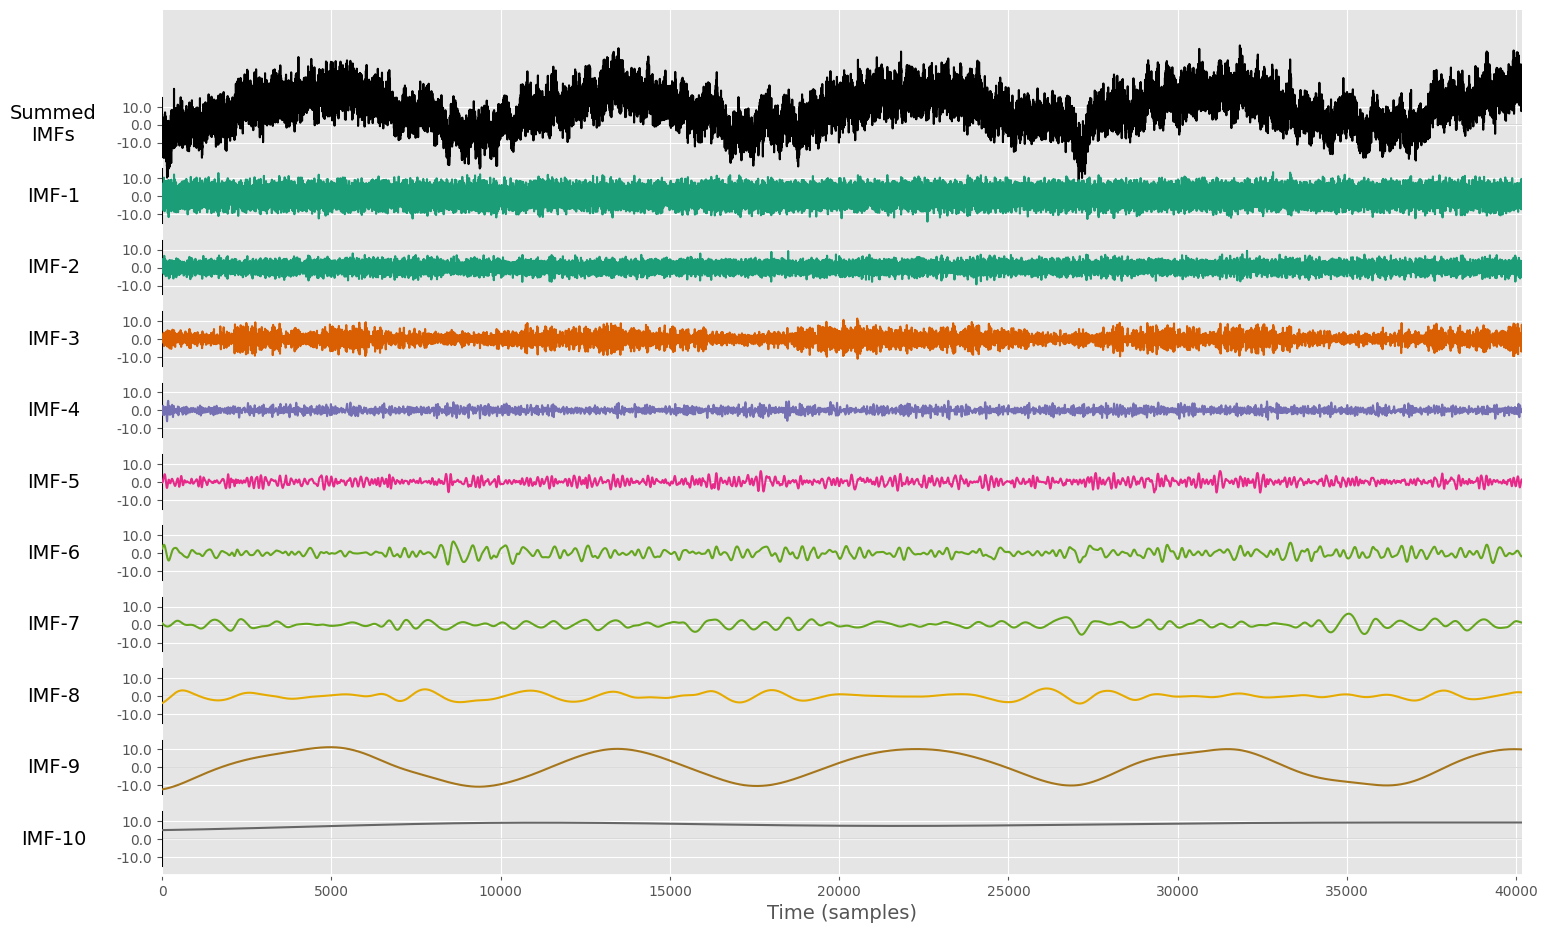

In [8]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [9]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,-2.217902,0.467868,-1.419637,-2.363546,-0.429221,2.623530,0.724971,-3.886952,-12.180348,4.878837
1,2.243937,3.657391,-1.679163,-2.135655,-0.449659,2.692199,0.704830,-3.878539,-12.177299,4.879146
2,0.946622,4.751025,-1.870788,-1.872443,-0.464052,2.760348,0.684774,-3.870058,-12.174239,4.879455
3,-1.967454,1.964923,-1.962957,-1.583152,-0.472573,2.827939,0.664804,-3.861507,-12.171168,4.879765
4,-5.147734,-1.646047,-1.917060,-1.276779,-0.475395,2.894931,0.644921,-3.852889,-12.168085,4.880074
...,...,...,...,...,...,...,...,...,...,...
40174,-1.957852,-4.236265,-0.056671,0.499706,1.294854,-1.715407,1.110381,2.008328,10.011707,9.115815
40175,-2.305373,-3.022959,-1.595221,0.506671,1.270628,-1.705856,1.107861,2.006085,10.010412,9.115806
40176,-0.348554,-3.192141,-2.744213,0.497210,1.243019,-1.695362,1.105459,2.003823,10.009113,9.115797
40177,5.838060,-3.539913,-3.286909,0.471294,1.211871,-1.683940,1.103176,2.001543,10.007808,9.115789


In [99]:
# imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
# imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

# imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
# imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

# imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
# imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

# imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
# imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

# imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
# imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

# imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
# imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

# imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
# imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

# imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
# imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

# imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
# imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

# imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
# imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

# # imf11_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# # imf11_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_11'])
# # imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_test))

In [100]:
# imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

# imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
#                 imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
#                 imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

In [ ]:
# plt.plot(imf_eemd_fc,label = 'predict', linewidth = 0.5, color = 'r')
# plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
# plt.legend()
# plt.show()

# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
# MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
# MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
# print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [ ]:
# plt.plot(imf_eemd_fc[:400], label = 'predict', linewidth = 0.5, color = 'r')
# plt.plot(test[:400].values, label = 'actual', linewidth = 0.3, color = 'k')
# plt.legend()
# plt.show()

# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
# MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
# MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
# print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [103]:
# imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
# imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
# imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
# imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
# imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
# imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
# imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
# imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
# imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))
# imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_train))
# # imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_train))

# imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
#                 imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
#                 imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

In [ ]:
# def dummy1(c):
#     global train
#     global imf_eemd_fc_train
#     return mean_squared_error(train, imf_eemd_fc_train + c)

# res1 = minimize(dummy1, 0, method='nelder-mead',
#                options={'xatol': 1e-8, 'disp': True})
# print(res1.x)

In [ ]:
# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
# MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
# MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
# print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [ ]:
# plt.plot(imf_eemd_fc + res1.x[0], label = 'predict', linewidth = 0.5, color = 'r')
# plt.plot(test.values, label = 'actual', linewidth = 0.3, color = 'k')
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(imf_eemd_fc[:400] + res1.x[0], label = 'predict', linewidth = 0.5, color = 'r')
# plt.plot(test.values[:400], label = 'actual', linewidth = 0.3, color = 'k')
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(arima_fc.values[:200], label = 'ARIMA', linewidth = 0.5)
# plt.plot(arima_SVR_fc[:200]+arima_fc.values[:200], label = 'ARIMA-SVM', linewidth = 0.5)
# plt.plot(hw_fc.values[:200], label = 'HW', linewidth = 0.5)
# plt.plot(hw_SVR_fc[:200]+hw_fc.values[:200], label = 'HW-SVM', linewidth = 0.5)
# plt.plot(SVR_fc[:200], label = 'SVM', linewidth = 0.5)
# plt.plot(SVR_MA_3_fc[0:200], label = 'SMA-SVM', linewidth = 0.5)
# plt.plot(imf_fc[:200], label = 'EMD-SVM', linewidth = 0.5)
# plt.plot(imf_fc[:200] + res.x[0], label = 'Improved EMD-SVM', linewidth = 0.5)
# plt.plot(imf_eemd_fc[:200], label = 'EEMD-SVM', linewidth = 0.5)
# plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'Improved EEMD-SVM', linewidth = 0.5)
# plt.plot(test.values[:200], label = 'Actual')
# plt.legend()
# plt.show()

In [ ]:
# start = 100
# end = 200

# plt.plot(SVR_fc[start:end], label = 'SVM', linewidth = 0.5)
# plt.plot(imf_fc[start:end], label = 'EMD-SVM', linewidth = 0.5)
# plt.plot(imf_fc[start:end] + res.x[0], label = 'Improved EMD-SVM', linewidth = 0.5)
# # plt.plot(imf_eemd_fc[start:end], label = 'EEMD-SVM', linewidth = 0.5)
# plt.plot(imf_eemd_fc[start:end] + res1.x[0], label = 'Improved EEMD-SVM', linewidth = 0.5)
# plt.plot(test.values[start:end], label = 'Actual', c = 'k')
# plt.legend()
# plt.show()

# EEMD

2. Descomposición Empírica en Modo (EEMD)

<Axes: xlabel='Time (samples)'>

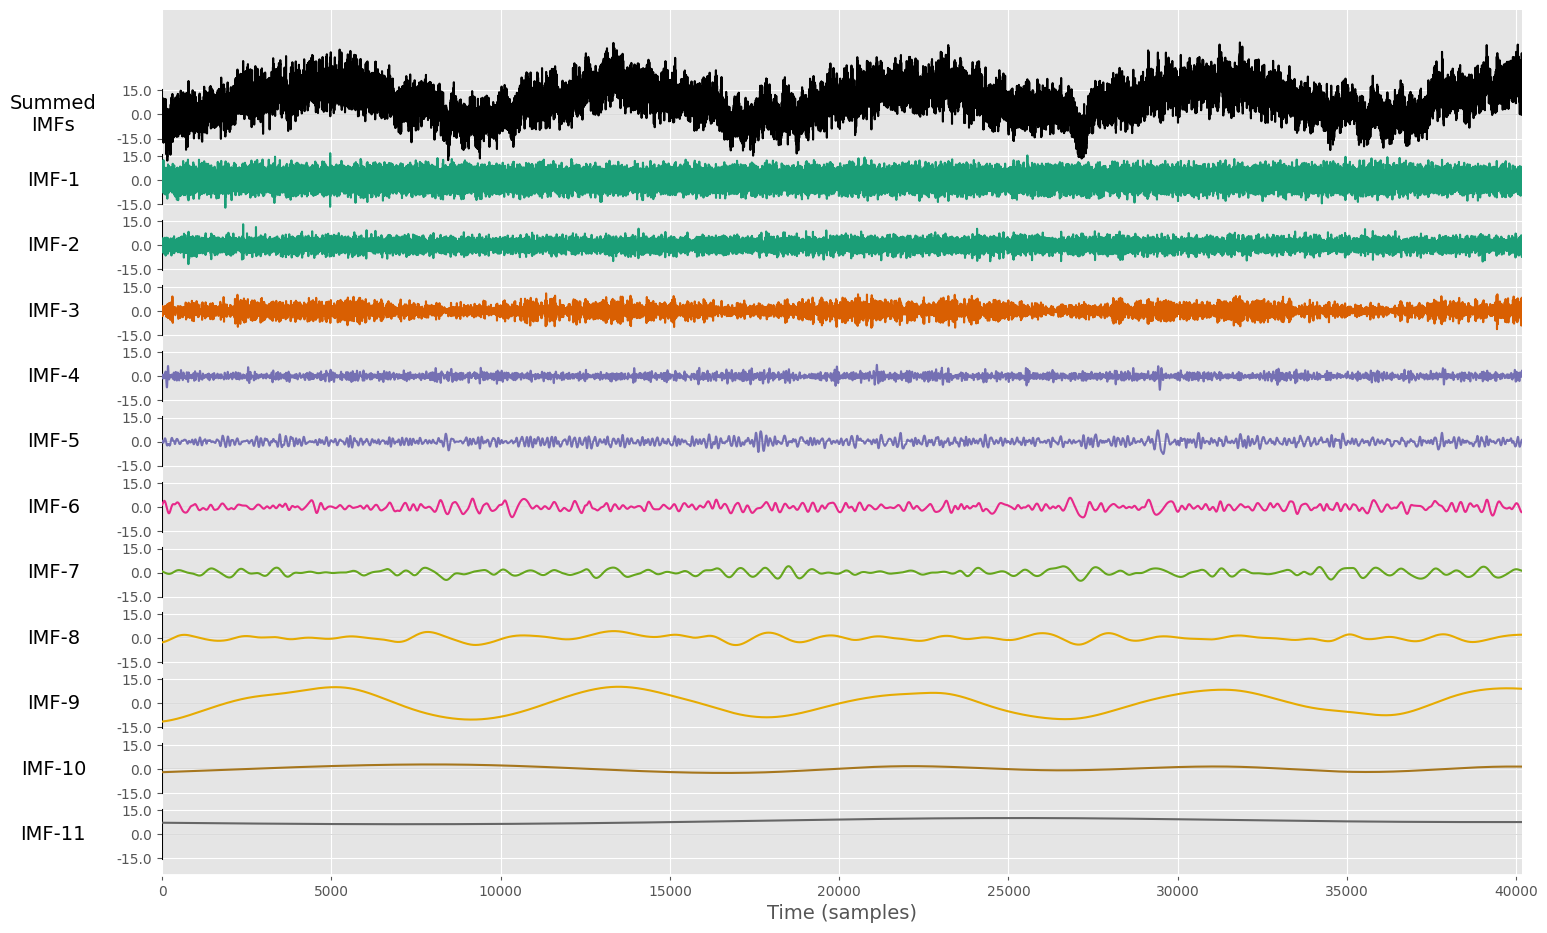

In [10]:
import numpy as np
import pandas as pd
import emd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.optimize import minimize

# Realizar la descomposición EEMD
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

3. Conversión de IMFs a DataFrame

In [18]:
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10,imf_eemd_11
0,7.567982,0.177586,-3.030983,-1.264267,0.516257,1.576556,0.741985,-2.692897,-11.309681,-2.055084,7.264422
1,2.848223,-1.913029,-2.203989,-1.307772,0.481170,1.624028,0.730741,-2.689038,-11.307198,-2.054330,7.264208
2,-2.396460,-1.811805,-1.139856,-1.325033,0.445133,1.672107,0.719530,-2.685136,-11.304708,-2.053575,7.263994
3,1.578073,0.003392,0.025986,-1.313242,0.407715,1.720757,0.708352,-2.681192,-11.302209,-2.052821,7.263780
4,0.687907,2.587774,1.150708,-1.269630,0.368531,1.769931,0.697205,-2.677206,-11.299703,-2.052066,7.263565
...,...,...,...,...,...,...,...,...,...,...,...
40174,0.061345,-0.030681,-3.633253,3.592165,1.296922,-3.208488,1.114044,2.073170,9.173792,1.446154,7.680873
40175,-0.423537,-0.177893,-4.305732,3.605502,1.306002,-3.205245,1.108222,2.073190,9.172428,1.445918,7.680902
40176,-5.561004,-2.314393,-4.549982,3.577174,1.312024,-3.200949,1.102463,2.073203,9.171061,1.445682,7.680931
40177,6.737057,-5.049043,-4.381089,3.509414,1.315024,-3.195608,1.096766,2.073210,9.169691,1.445444,7.680960


4. Construcción y Ajuste de Modelos ARIMA para Cada IMF

In [12]:
# imf_arima_models = []
# imf_arima_forecasts = []

# for i in range(imf_eemd.shape[1]):
#     imf_series = imf_eemd_df['imf_eemd_{}'.format(i+1)]
#     model = ARIMA(imf_series, order=(2, 1, 5)).fit()
#     imf_arima_models.append(model)
#     forecast = model.forecast(len(test))
#     imf_arima_forecasts.append(forecast)

5. Suma de las Predicciones de los IMFs

In [14]:
# imf_arima_fc = np.sum(imf_arima_forecasts, axis=0)

6. Predicciones para el Conjunto de Entrenamiento

In [15]:
# imf_arima_train_forecasts = []

# for i in range(imf_eemd.shape[1]):
#     model = imf_arima_models[i]
#     forecast = model.predict(start=0, end=len(train)-1)
#     imf_arima_train_forecasts.append(forecast)

# imf_arima_fc_train = np.sum(imf_arima_train_forecasts, axis=0)

7. Optimización de la Predicción

In [ ]:
# def dummy1(c):
#     global train
#     global imf_arima_fc_train
#     return mean_squared_error(train, imf_arima_fc_train + c)

# res1 = minimize(dummy1, 0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
# print(res1.x)

8. Graficar las Predicciones

In [26]:
# # Ajustar las predicciones con el valor óptimo de c
# imf_arima_fc += res1.x

# # Convertir las predicciones y los datos de prueba en series de pandas
# fc_series = pd.Series(imf_arima_fc, index=[x for x in range(len(train), len(train) + len(test))])
# test_series = pd.Series(test, index=[x for x in range(len(train), len(train) + len(test))])

# # Graficar las predicciones y los datos reales
# plt.plot(test_series, label='actual', linewidth=0.5, c='k')
# plt.plot(fc_series, label='forecast', linewidth=0.5, c='r')
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=12)
# plt.show()

# # Calcular y mostrar las métricas de error
# RMSE_ARIMA = mean_squared_error(test, imf_arima_fc)
# MAE_ARIMA = mean_absolute_error(test, imf_arima_fc)
# MAPE_ARIMA = mean_absolute_percentage_error(test, imf_arima_fc)
# print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))

In [21]:
from pmdarima.arima import auto_arima

imf_arima_models = []
imf_arima_forecasts = []

for i in range(imf_eemd.shape[1]):
    imf_series = imf_eemd_df['imf_eemd_{}'.format(i+1)]
    
    auto_arima_model = auto_arima(imf_series,
                              start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              seasonal=True,
                            #   m=12,  # Periodo de estacionalidad
                              start_P=0, start_Q=0,
                              max_P=5, max_Q=5,
                              d=1, D=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
    
    # model = ARIMA(imf_series, order=(2, 1, 5)).fit()
    model = auto_arima_model.fit(imf_series)
    imf_arima_models.append(model)
    forecast = model.predict(n_periods=len(test), return_conf_int=True,
    freq = 'H',
    alpha=0.05)
    imf_arima_forecasts.append(forecast)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=19.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269494.453, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=252727.702, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=25.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=269492.453, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=243568.627, Time=2.53 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=238028.241, Time=2.47 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=234470.620, Time=3.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=232397.736, Time=3.79 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=61.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=53.78 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=232395.736, Time=2.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=234468.620, Time=2.03 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=25.83 sec
 ARIMA(4,1,1)(0,0,0)[0]            

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-511364.460, Time=18.75 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-520516.003, Time=13.32 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-850355.268, Time=22.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-528613.500, Time=13.84 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-864085.956, Time=46.50 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=157.94 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-849902.675, Time=42.76 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=nan sec

Best model:  ARIMA(5,1,3)(0,0,0)[0] intercept
Total fit time: 507.952 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-611621.775, Time=14.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-236885.674, Time=3.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=21.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-236887.655, Time=1.75 sec
 AR

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-850957.788, Time=13.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-924991.633, Time=24.93 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-850655.142, Time=14.76 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-851227.731, Time=19.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851376.749, Time=21.70 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-850083.626, Time=28.17 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-851334.340, Time=65.52 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-875702.541, Time=4.84 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 375.415 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-763292.503, Time=31.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-314511.039, Time=3.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=11.97 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=22.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-314488.809, Time=1.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=13.26 sec
 ARIM

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-851248.056, Time=13.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851246.168, Time=16.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-763288.286, Time=40.03 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-851248.473, Time=13.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=29.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-851032.756, Time=25.64 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=25.93 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-851223.817, Time=19.79 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=nan sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 371.286 seconds
Performing stepwise search to minimize aic


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-845311.048, Time=9.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-318230.033, Time=3.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=6.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=20.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-317744.172, Time=1.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=22.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-845338.195, Time=29.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=30.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-845020.005, Time=15.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=39.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851895.783, Time=28.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-702229.436, Time=56.98 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-851245.667, Time=50.46 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-845346.423, Time=18.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-851217.484, Time=42.63 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-794767.579, Time=105.66 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-889141.930, Time=32.00 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=nan sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-866011.594, Time=5.97 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-637145.242, Time=20.48 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-972498.159, Time=27.20 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=-844863.392, Time=7.46 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=-877053.747, Time=37.82 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,5)(0,0,0)[0]             : AIC=-859012.162, Time=9.49 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=-731366.955, Time=51.00 sec

Best model:  ARIMA(2,1,4)(0,0,0)[0]          
Total fit time: 706.918 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-851843.960, Time=37.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-467216.447, Time=5.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=30.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-467214.447, Time=5.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-466637.870, Time=1.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=24.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-851985.909, Time=56.08 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-467212.442, Time=9.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-467207.341, Time=46.67 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-851192.233, Time=14.53 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-467208.888, Time=14.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-467205.534, Time=43.88 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-896434.250, Time=7.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-466633.864, Time=3.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-926868.522, Time=16.93 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-466635.870, Time=3.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=inf, Time=5.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=11.27 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-464991.313, Time=6.15 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-464987.474, Time=9.91 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 352.478 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-852013.858, Time=17.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-567295.846, Time=4.92 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=9.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-567293.613, Time=13.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-567197.982, Time=1.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=28.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-567268.875, Time=35.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-567270.831, Time=29.41 sec
 ARIMA(

In [ ]:
def dummy1(c):
    global train
    global imf_arima_fc_train
    return mean_squared_error(train, imf_arima_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
print(res1.x)

In [ ]:
imf_arima_fc = np.sum(imf_arima_forecasts, axis=0)
# res1 = minimize(dummy1, 0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

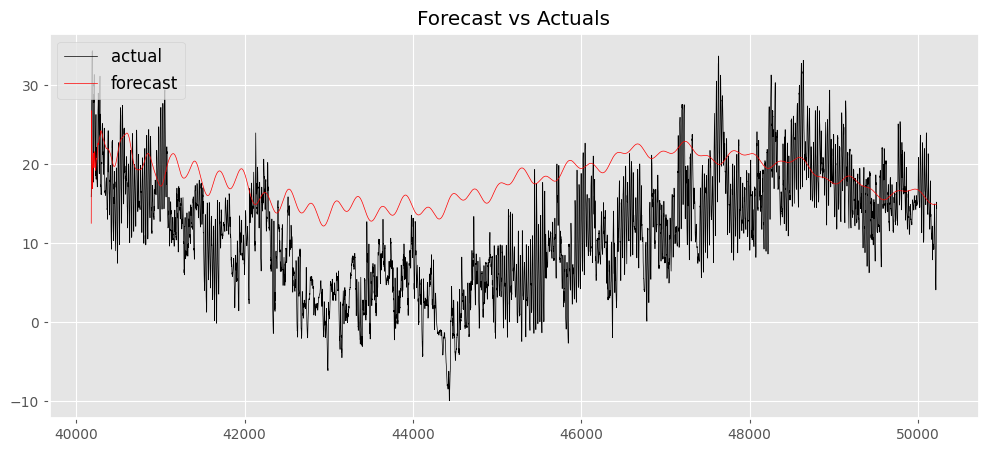

RMSE = 84.19340153183516 
MAE = 7.748227870890779 
MAPE = 14694086693665.04


In [25]:
# Ajustar las predicciones con el valor óptimo de c
imf_arima_fc += res1.x

# Convertir las predicciones y los datos de prueba en series de pandas
fc_series = pd.Series(imf_arima_fc, index=[x for x in range(len(train), len(train) + len(test))])
test_series = pd.Series(test, index=[x for x in range(len(train), len(train) + len(test))])

# Graficar las predicciones y los datos reales
plt.plot(test_series, label='actual', linewidth=0.5, c='k')
plt.plot(fc_series, label='forecast', linewidth=0.5, c='r')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Calcular y mostrar las métricas de error
RMSE_ARIMA = mean_squared_error(test, imf_arima_fc)
MAE_ARIMA = mean_absolute_error(test, imf_arima_fc)
MAPE_ARIMA = mean_absolute_percentage_error(test, imf_arima_fc)
print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))

# LSTM

In [56]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [37]:
def prepare_data_for_lstm(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
        
    return np.array(X), np.array(y)

In [44]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(train_data, val_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, val_scaled, test_scaled, scaler

In [38]:
def split_data(data, train_size=0.7, val_size=0.15):
    train_idx = int(len(data) * train_size)
    val_idx = int(len(data) * (train_size + val_size))
    
    train_data = data[:train_idx]
    val_data = data[train_idx:val_idx]
    test_data = data[val_idx:]
    
    return train_data, val_data, test_data

In [46]:
def train_lstm_model(X_train, y_train, X_val, y_val, n_epochs=50):
    model = create_lstm_model((X_train.shape[1], 1))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=2)
    return model, history

In [47]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

In [63]:
# 4. Prediction and Visualization
def predict_and_evaluate(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    print(f'Test MSE: {mse}')
    
    plt.plot(y_test_rescaled, label='True Data')
    plt.plot(predictions_rescaled, label='Predictions')
    plt.legend()
    plt.title('Predictions vs True Data')
    plt.show()

    return predictions_rescaled #, mse

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 13s - 29ms/step - loss: 0.0201 - val_loss: 0.0154
Epoch 2/4
440/440 - 8s - 18ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 3/4
440/440 - 8s - 18ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 4/4
440/440 - 8s - 18ms/step - loss: 0.0138 - val_loss: 0.0134


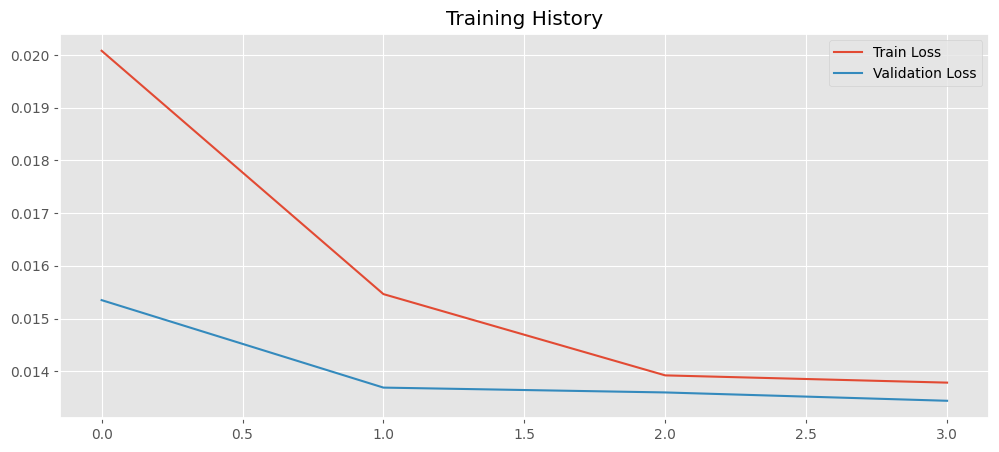

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 15.912938468412428


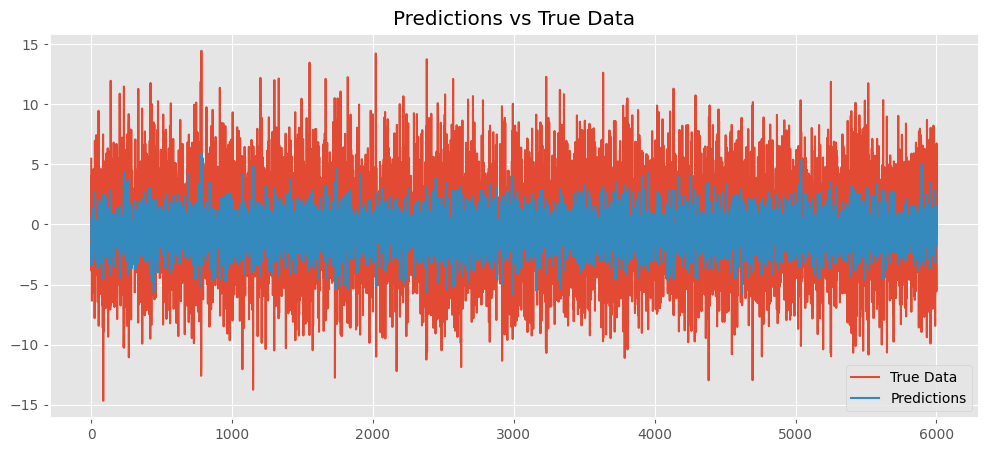

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 11s - 25ms/step - loss: 0.0139 - val_loss: 0.0096
Epoch 2/4
440/440 - 8s - 18ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 3/4
440/440 - 8s - 18ms/step - loss: 9.2124e-04 - val_loss: 7.6425e-04
Epoch 4/4
440/440 - 8s - 19ms/step - loss: 6.1387e-04 - val_loss: 5.8132e-04


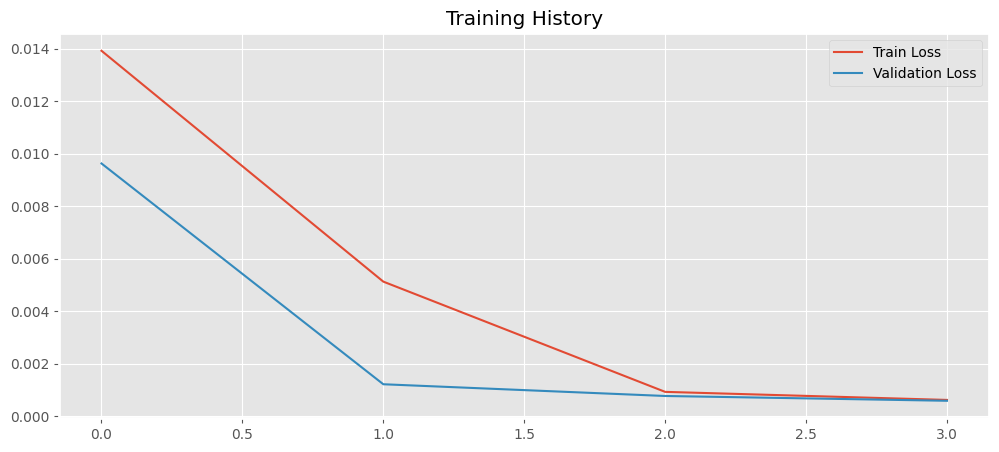

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 0.3498569230525908


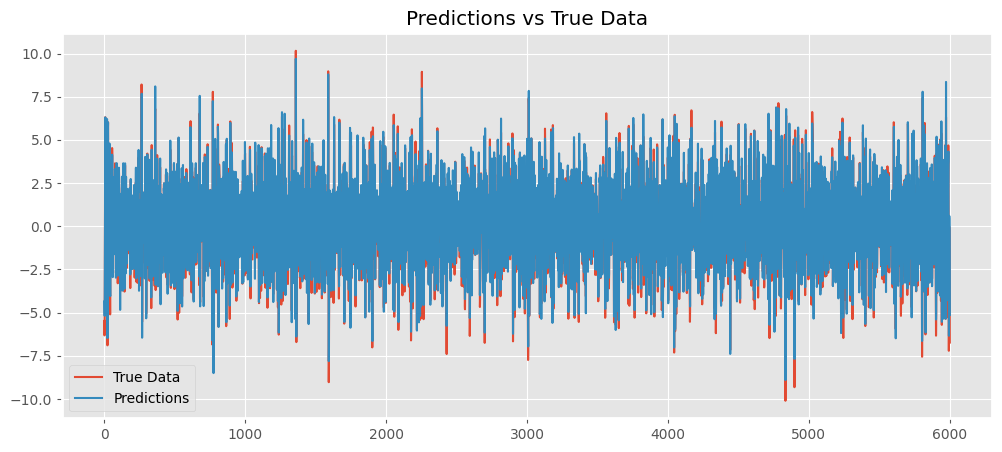

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 12s - 28ms/step - loss: 0.0100 - val_loss: 0.0010
Epoch 2/4
440/440 - 9s - 20ms/step - loss: 4.3958e-04 - val_loss: 2.0537e-04
Epoch 3/4
440/440 - 8s - 19ms/step - loss: 1.3963e-04 - val_loss: 8.7987e-05
Epoch 4/4
440/440 - 8s - 18ms/step - loss: 9.7226e-05 - val_loss: 6.3761e-05


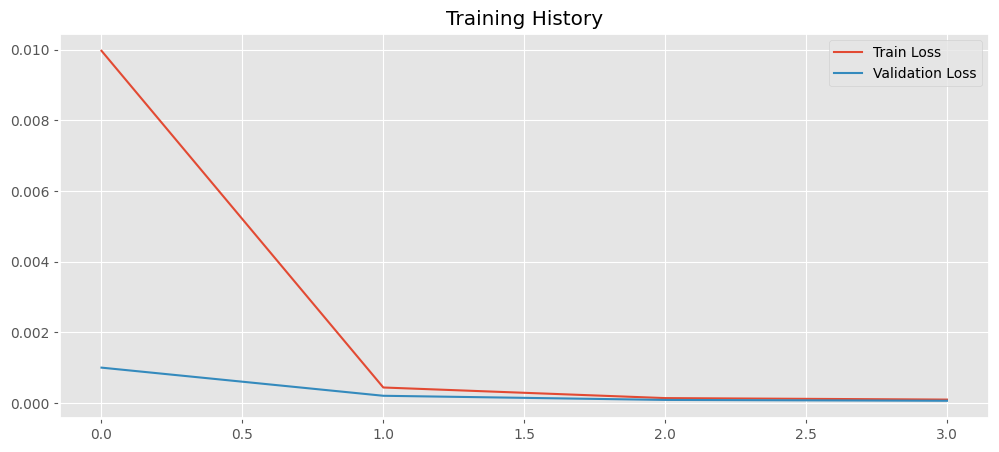

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 0.02441266347281538


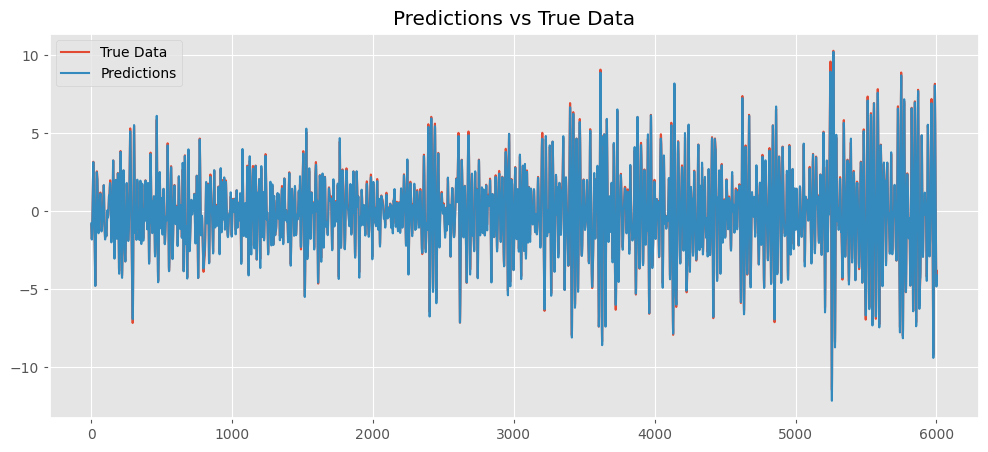

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 11s - 26ms/step - loss: 0.0055 - val_loss: 9.5323e-04
Epoch 2/4
440/440 - 8s - 18ms/step - loss: 3.2352e-04 - val_loss: 1.5251e-04
Epoch 3/4
440/440 - 8s - 18ms/step - loss: 1.1136e-04 - val_loss: 7.2809e-05
Epoch 4/4
440/440 - 8s - 19ms/step - loss: 5.5713e-05 - val_loss: 1.7587e-04


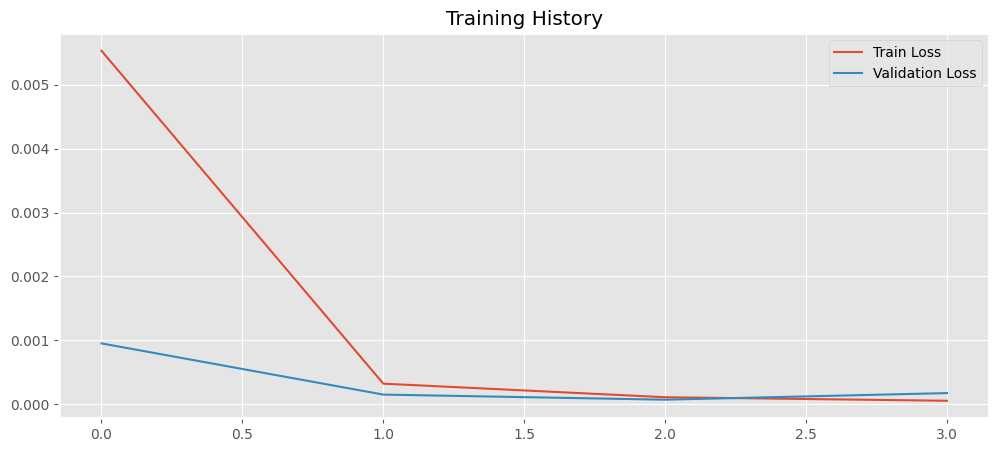

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test MSE: 0.010148418090022173


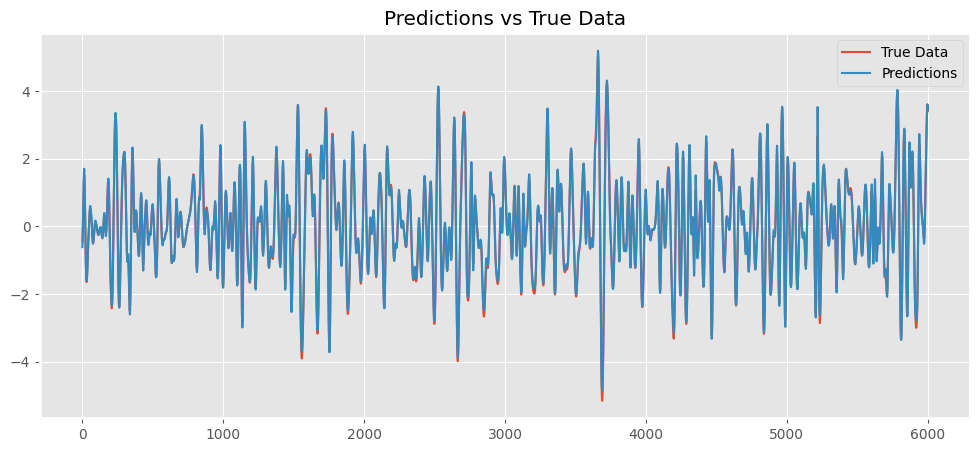

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 11s - 26ms/step - loss: 0.0022 - val_loss: 1.2886e-04
Epoch 2/4
440/440 - 8s - 18ms/step - loss: 8.5738e-05 - val_loss: 1.0143e-04
Epoch 3/4
440/440 - 8s - 19ms/step - loss: 6.1918e-05 - val_loss: 7.3798e-05
Epoch 4/4
440/440 - 8s - 18ms/step - loss: 4.0671e-05 - val_loss: 4.2511e-05


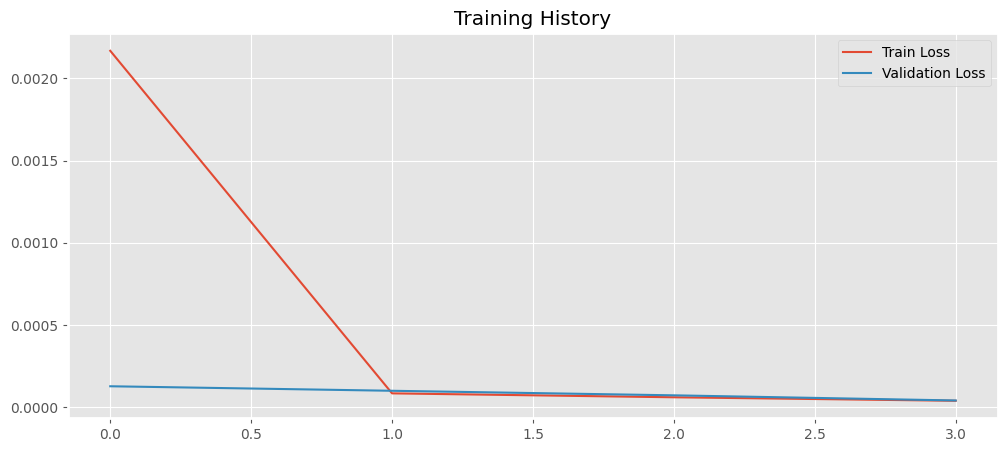

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 0.004033732755900907


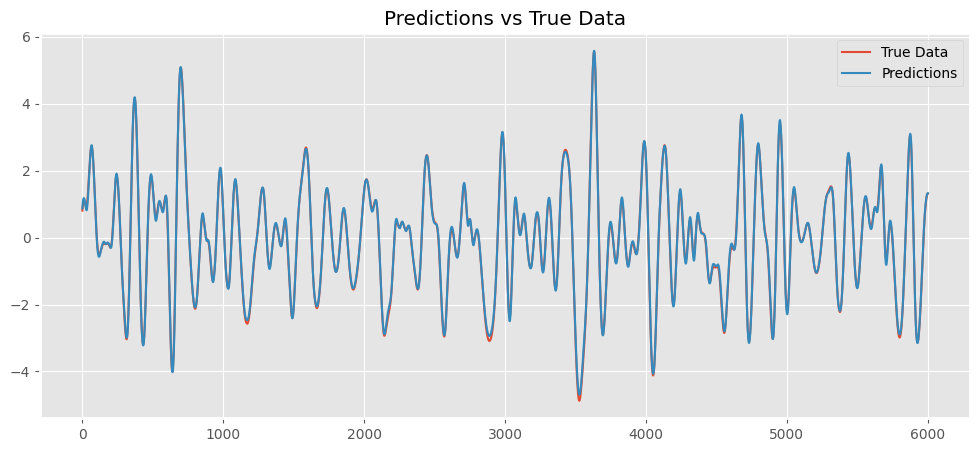

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 11s - 25ms/step - loss: 0.0032 - val_loss: 9.7657e-05
Epoch 2/4
440/440 - 8s - 19ms/step - loss: 2.6353e-05 - val_loss: 8.4769e-06
Epoch 3/4
440/440 - 8s - 19ms/step - loss: 1.6428e-05 - val_loss: 1.3681e-05
Epoch 4/4
440/440 - 8s - 18ms/step - loss: 1.2291e-05 - val_loss: 8.4890e-06


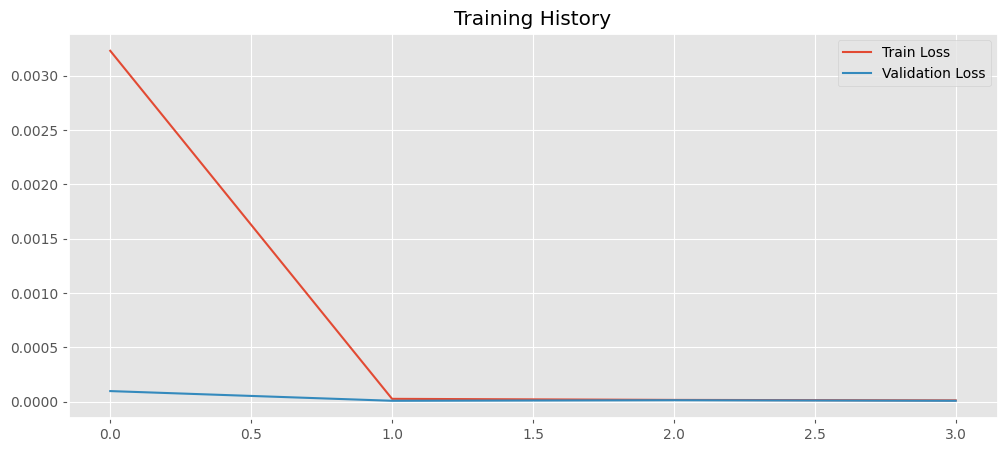

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 0.002022748341806515


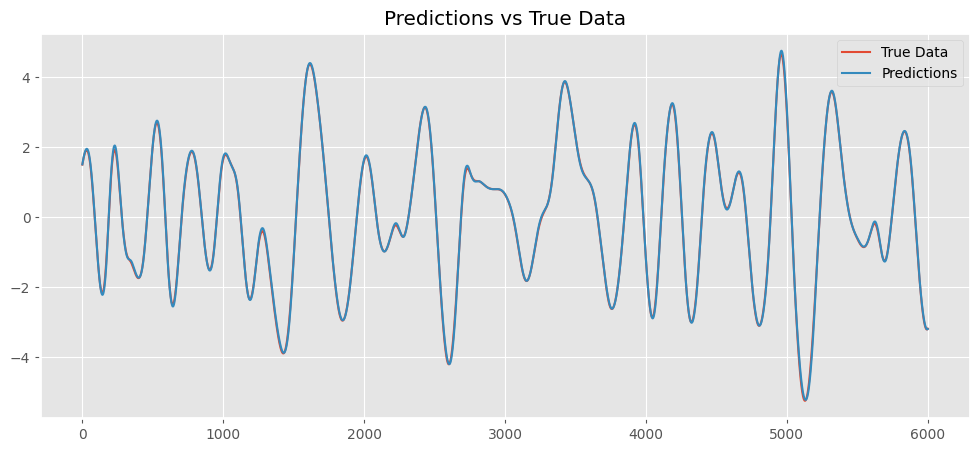

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 11s - 26ms/step - loss: 0.0029 - val_loss: 9.2861e-05
Epoch 2/4
440/440 - 8s - 19ms/step - loss: 9.8365e-05 - val_loss: 6.3554e-05
Epoch 3/4
440/440 - 8s - 18ms/step - loss: 3.7282e-05 - val_loss: 5.9903e-06
Epoch 4/4
440/440 - 8s - 18ms/step - loss: 5.9996e-06 - val_loss: 1.0055e-06


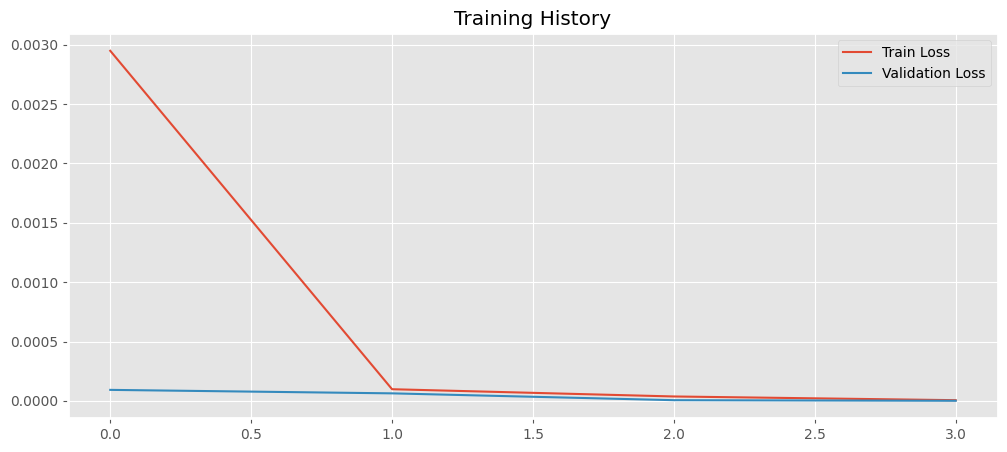

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 0.0003580707930811308


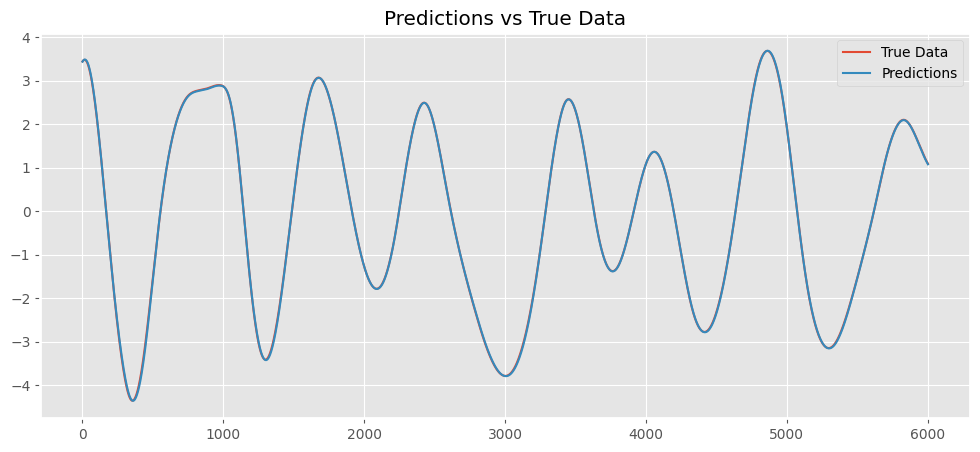

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 12s - 27ms/step - loss: 0.0021 - val_loss: 2.0375e-05
Epoch 2/4
440/440 - 8s - 18ms/step - loss: 3.3265e-05 - val_loss: 2.1745e-05
Epoch 3/4
440/440 - 8s - 19ms/step - loss: 2.7545e-05 - val_loss: 3.8883e-05
Epoch 4/4
440/440 - 8s - 19ms/step - loss: 2.4205e-05 - val_loss: 1.4261e-05


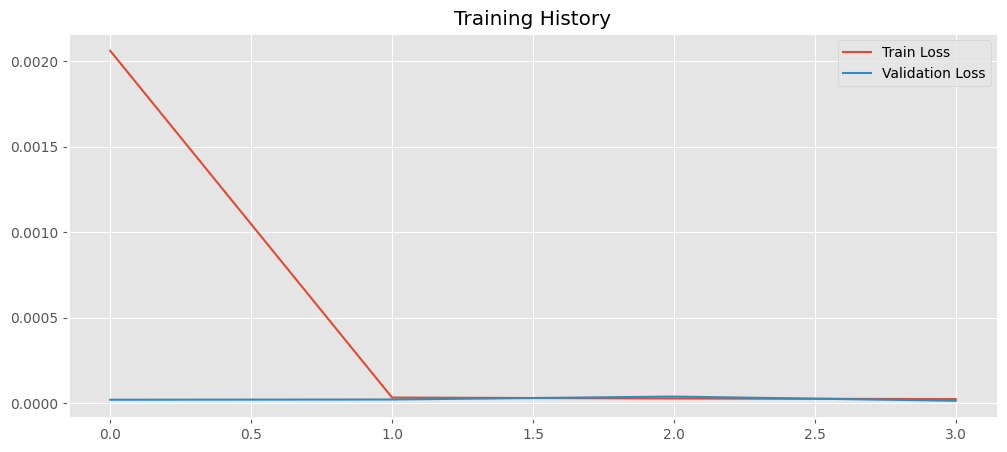

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test MSE: 0.0014251624773530397


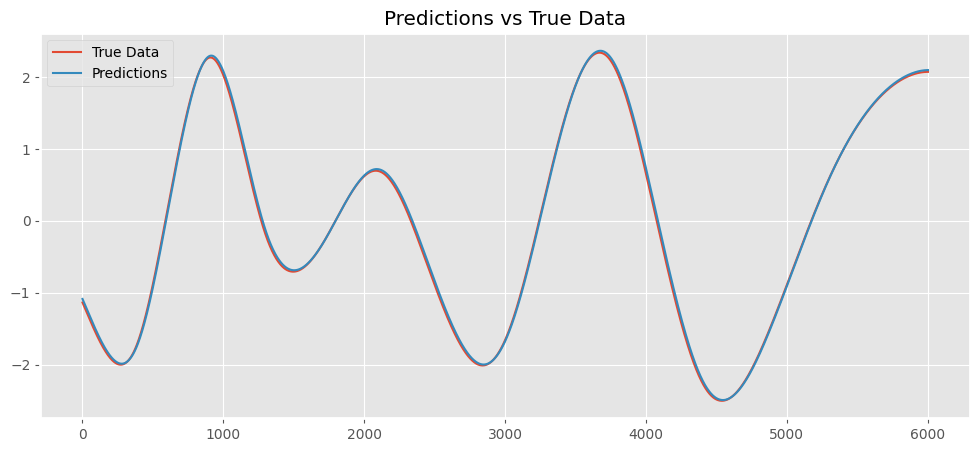

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 11s - 25ms/step - loss: 0.0043 - val_loss: 1.2867e-05
Epoch 2/4
440/440 - 8s - 18ms/step - loss: 1.3474e-05 - val_loss: 9.2499e-06
Epoch 3/4
440/440 - 9s - 19ms/step - loss: 8.5598e-06 - val_loss: 7.6495e-06
Epoch 4/4
440/440 - 8s - 18ms/step - loss: 5.0231e-06 - val_loss: 3.9708e-06


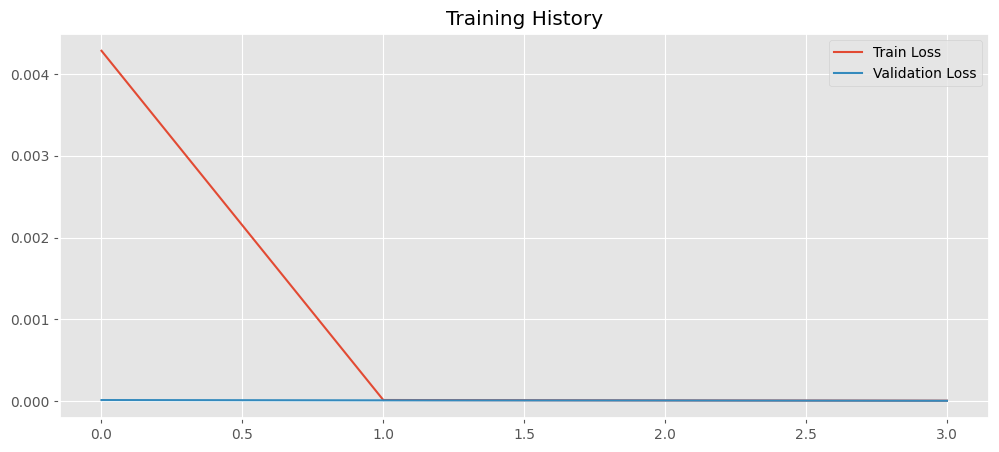

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 0.0010912082989867678


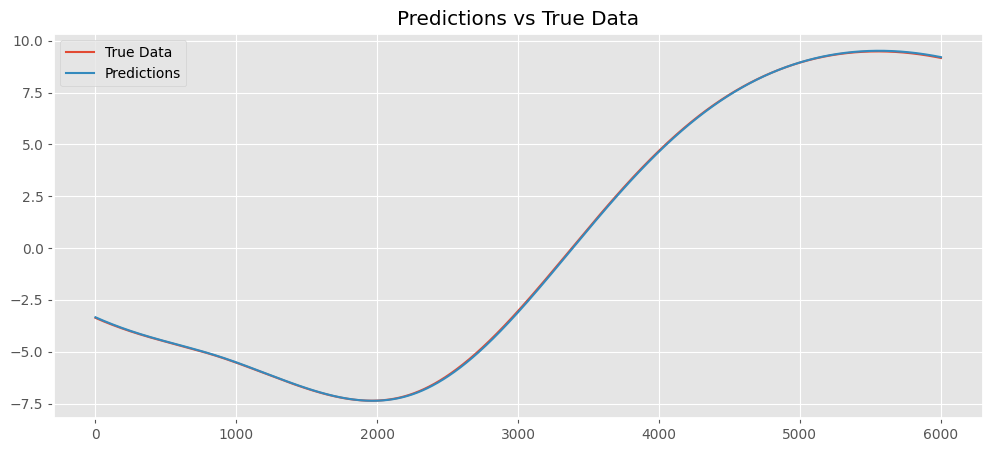

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 12s - 26ms/step - loss: 0.0052 - val_loss: 1.5030e-05
Epoch 2/4
440/440 - 8s - 19ms/step - loss: 1.6161e-05 - val_loss: 1.9969e-05
Epoch 3/4
440/440 - 8s - 18ms/step - loss: 9.7987e-06 - val_loss: 2.0297e-06
Epoch 4/4
440/440 - 8s - 18ms/step - loss: 4.7002e-06 - val_loss: 1.9074e-06


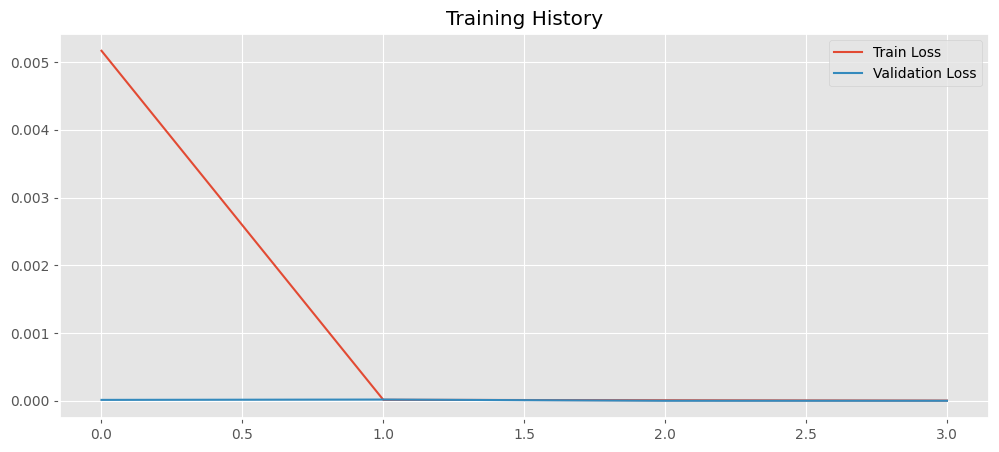

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 9.044334934584983e-05


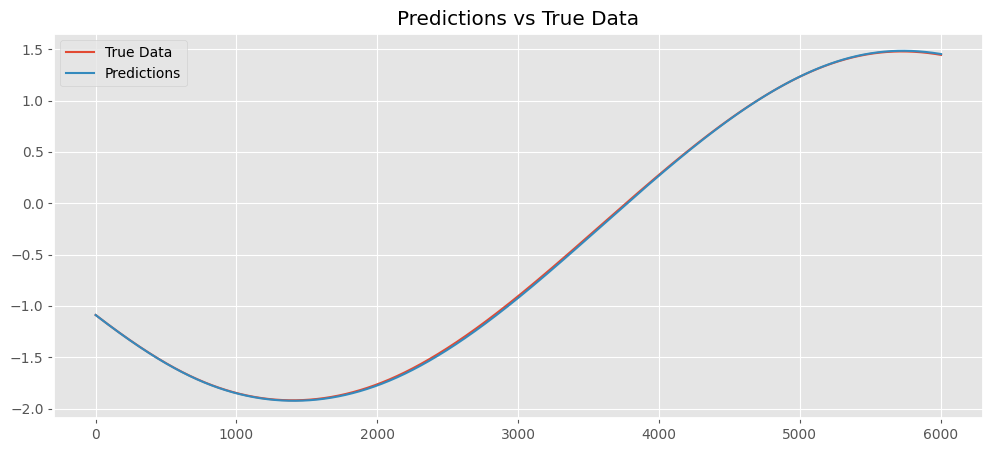

Epoch 1/4


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


440/440 - 12s - 28ms/step - loss: 0.0015 - val_loss: 2.9865e-05
Epoch 2/4
440/440 - 8s - 19ms/step - loss: 7.1692e-06 - val_loss: 1.5024e-05
Epoch 3/4
440/440 - 8s - 18ms/step - loss: 5.0238e-06 - val_loss: 2.2524e-05
Epoch 4/4
440/440 - 9s - 21ms/step - loss: 3.0864e-06 - val_loss: 6.3115e-06


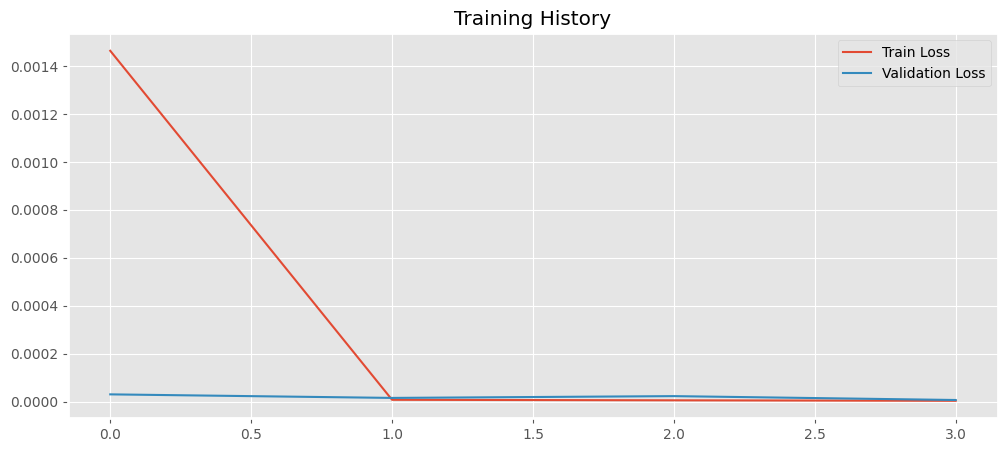

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test MSE: 1.0313554313587096e-05


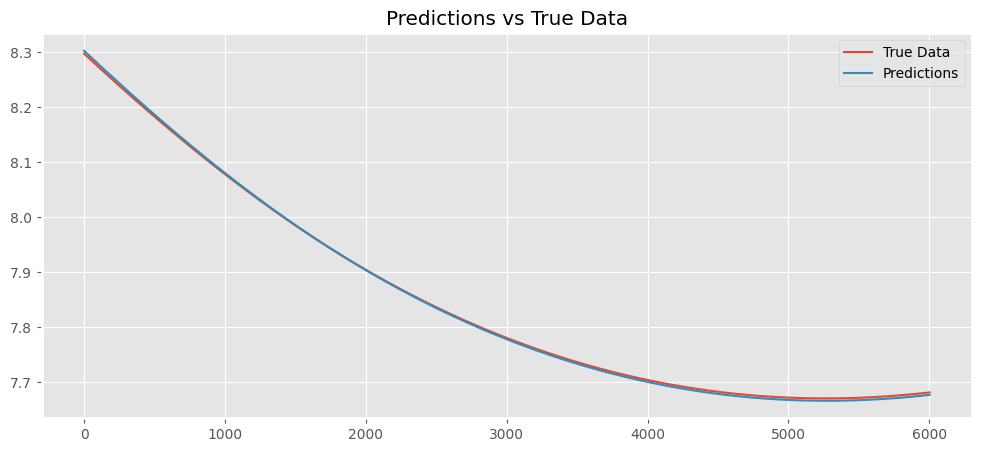

In [65]:
from pmdarima.arima import auto_arima

imf_lstm_models = []
imf_lstm_forecasts = []
n_steps = 24
n_epochs = 4

for i in range(imf_eemd.shape[1]):
    imf_series = imf_eemd_df['imf_eemd_{}'.format(i+1)]
    
    train_data, val_data, test_data = split_data(imf_series)
    
    # convertir a dataframe
    train_data = pd.DataFrame(train_data)
    val_data = pd.DataFrame(val_data)
    test_data = pd.DataFrame(test_data)
    
    train_scaled, val_scaled, test_scaled, scaler = scale_data(train_data, val_data, test_data)

    X_train, y_train = prepare_data_for_lstm(train_scaled, n_steps)
    X_val, y_val = prepare_data_for_lstm(val_scaled, n_steps)
    X_test, y_test = prepare_data_for_lstm(test_scaled, n_steps)
    
    # train a lstm model for each imf
    # model = create_lstm_model((X_train.shape[1], 1))
    model, history = train_lstm_model(X_train, y_train, X_val, y_val, n_epochs)
    plot_training_history(history)
    
        
    # # model = ARIMA(imf_series, order=(2, 1, 5)).fit()
    # model = auto_arima_model.fit(imf_series)
    imf_lstm_models.append(model)    
    forecast = predict_and_evaluate(model, X_test, y_test, scaler)
    imf_lstm_forecasts.append(forecast)
    
    # forecast = model.predict(n_periods=len(test), return_conf_int=True,
    # freq = 'H',
    # alpha=0.05)
    # imf_arima_forecasts.append(forecast)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MSE: 2.2443065439563137e-06


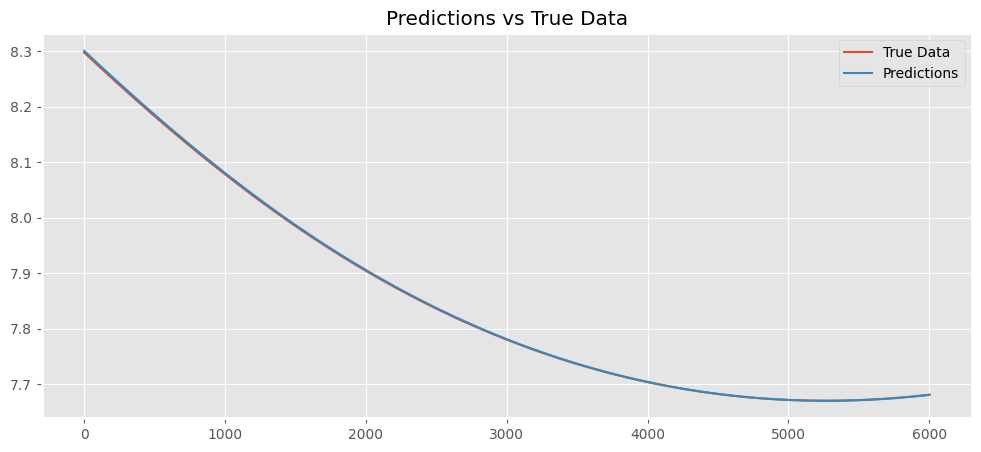

In [51]:
predictions, mse = predict_and_evaluate(model, X_test, y_test, scaler)

In [ ]:
imf_lstm_fc = np.sum(imf_lstm_forecasts, axis=0)

# Ajustar las predicciones con el valor óptimo de c
imf_lstm_fc += res1.x

# Convertir las predicciones y los datos de prueba en series de pandas
fc_series_lstm = pd.Series(imf_lstm_fc, index=[x for x in range(len(train), len(train) + len(test))])
test_series = pd.Series(test, index=[x for x in range(len(train), len(train) + len(test))])

# Graficar las predicciones y los datos reales
plt.plot(test_series, label='actual', linewidth=0.5, c='k')
plt.plot(fc_series_lstm, label='forecast', linewidth=0.5, c='r')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Calcular y mostrar las métricas de error
RMSE_LSTM = mean_squared_error(test, imf_lstm_fc)
MAE_LSTM = mean_absolute_error(test, imf_lstm_fc)
MAPE_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc)
print('RMSE = {}'.format(RMSE_LSTM), '\nMAE = {}'.format(MAE_LSTM), '\nMAPE = {}'.format(MAPE_LSTM))

ValueError: Length of values (6003) does not match length of index (0)

In [ ]:
imf_arima_fc_train = np.sum(imf_arima_train_forecasts, axis=0)

In [ ]:
imf_lstm_fc_train = np.sum(imf_lstm_train_forecasts, axis=0)

In [58]:
def dummy1(c):
    global train
    global imf_lstm_fc_train
    return mean_squared_error(train, imf_lstm_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
print(res1.x)

NameError: name 'imf_lstm_fc_train' is not defined

In [54]:
predictions

array([[38.323437],
       [38.322517],
       [38.321598],
       ...,
       [35.9347  ],
       [35.934814],
       [35.934925]], dtype=float32)

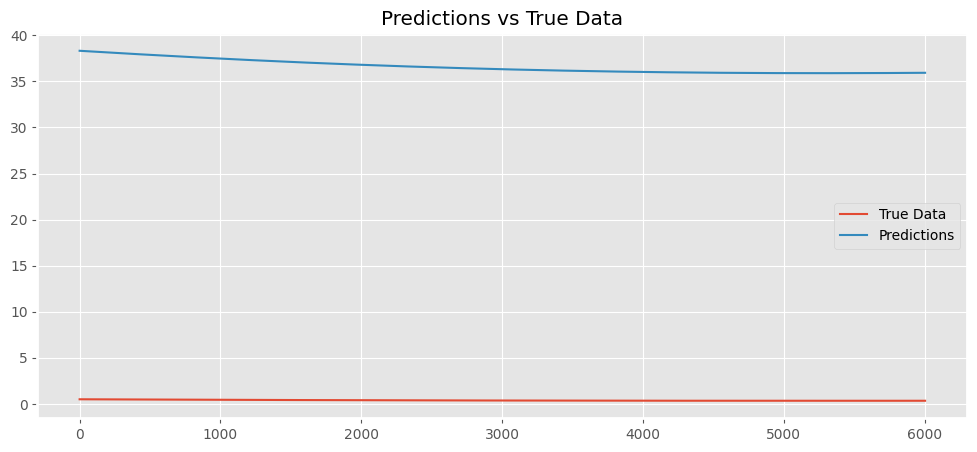

In [55]:
# plot predictions
plt.plot(y_test, label='True Data')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.show()